In [1]:
import torch
import matplotlib.pyplot as plt
import os
from datetime import datetime
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from natsort import natsorted

In [2]:
# directory = "IMF_ENVs/FEMTO/Bearing1_7/horizontal"
directory = "IMF_ENVs/XJTU-SY/Bearing2_2/combined"
fileList = []

for fileName in os.listdir(directory):
    filePath = os.path.join(directory, fileName)
    fileList.append(filePath)

sorted_file_list = natsorted(fileList)

R = 25600 # fs
N = 32768 # datapoints

BPFO = 115.61

BPFO2 = 2 * BPFO

BPFO3 = 3 * BPFO

BPFO4 = 4 * BPFO

def BPFO_index(N, R, BPFO):
    BPFO_idx = []
    BPFOs = []
    
    for k in range(N):
        f = (k / N) * R
        # print(k)
        # print(f)
        # print()

        if (f >= BPFO-1 and f <= BPFO+1): # all frequencies in the bin
            BPFO_idx.append(k)
            BPFOs.append(f)

    # print(min(BPFOs, key=lambda x:abs(x-BPFO)))
        
    return BPFO_idx

BPFO_idx = BPFO_index(N, R, BPFO)
BPFO2_idx = BPFO_index(N, R, BPFO2)
BPFO3_idx = BPFO_index(N, R, BPFO3)
BPFO4_idx = BPFO_index(N, R, BPFO4)


# #DIT IS EEN TEST OF HET MISS ZO WEL WERKT
BPFO_idx = [BPFO_idx[1]]
BPFO2_idx = [BPFO2_idx[1]]
BPFO3_idx = [BPFO3_idx[1]]
BPFO4_idx = [BPFO4_idx[1]]

print(BPFO_idx)
print(BPFO2_idx)
print(BPFO3_idx)
print(BPFO4_idx)

[148]
[296]
[444]
[592]


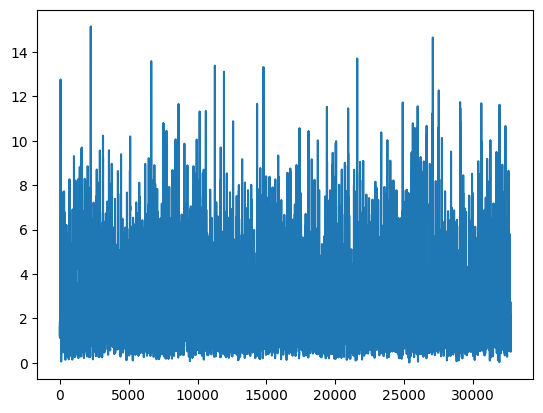

In [3]:
all_BPFOs = [] # values of the fft of the env of the imf at frequencies of the  BPFOs, [BPFO, BPFO2. BPFO3, BPFO4]
BPFO2 = []
BPFO3 = []
BPFO4 = []

fft_env_imf1_sorted = []

# Per file in sorted order, fft of the first imf's envelope is calulated
for filePath in sorted_file_list:
    tensor = torch.load(filePath, map_location=torch.device('cpu'))
    env_imf1 = tensor[0].cpu()
    
    # plt.plot(env_imf1)

    fft_env_imf1 = torch.fft.fft(env_imf1)
    fft_env_imf1_sorted.append(fft_env_imf1)

    BPFOs = []
    BPFOs.append([fft_env_imf1[i] for i in BPFO2_idx])  
    BPFOs.append([fft_env_imf1[i] for i in BPFO3_idx])  
    BPFOs.append([fft_env_imf1[i] for i in BPFO4_idx])
    all_BPFOs.append(BPFOs)

    BPFO2.append(fft_env_imf1[BPFO2_idx[0]])
    BPFO3.append(fft_env_imf1[BPFO3_idx[0]])
    BPFO4.append(fft_env_imf1[BPFO4_idx[0]])

plt.plot(env_imf1)

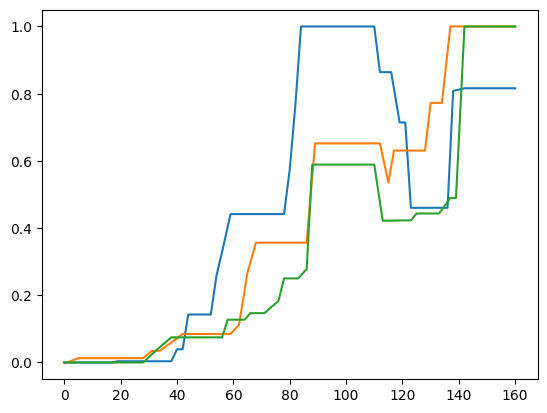

In [4]:
def amplitudes2(ffts_at_BPFO_freq):
    ffts_at_BPFO_freq = np.array(ffts_at_BPFO_freq)
    peaks, _ = find_peaks(np.abs(ffts_at_BPFO_freq))
    
    amplitudes = np.abs(ffts_at_BPFO_freq[peaks])

    return amplitudes, peaks

ampl_BPFO2, peak_idx_BPFO2 = amplitudes2(BPFO2)
ampl_BPFO3, peak_idx_BPFO3 = amplitudes2(BPFO3)
ampl_BPFO4, peak_idx_BPFO4 = amplitudes2(BPFO4)

# Define the window size
window_size = 4

# Pad the array to handle the edges
padded_ampl_BPFO2 = np.pad(ampl_BPFO2, pad_width=window_size, mode='edge')
padded_ampl_BPFO3 = np.pad(ampl_BPFO3, pad_width=window_size, mode='edge')
padded_ampl_BPFO4 = np.pad(ampl_BPFO4, pad_width=window_size, mode='edge')

# Create the new array based on the given rule
An_BPFO2 = np.array([np.max(padded_ampl_BPFO2[i:i + 2 * window_size + 1]) for i in range(len(ampl_BPFO2))])
An_BPFO2_norm = (An_BPFO2 - min(An_BPFO2)) / (max(An_BPFO2) - min(An_BPFO2))

An_BPFO3 = np.array([np.max(padded_ampl_BPFO3[i:i + 2 * window_size + 1]) for i in range(len(ampl_BPFO3))])
An_BPFO3_norm = (An_BPFO3 - min(An_BPFO3)) / (max(An_BPFO3) - min(An_BPFO3))

An_BPFO4 = np.array([np.max(padded_ampl_BPFO4[i:i + 2 * window_size + 1]) for i in range(len(ampl_BPFO4))])
An_BPFO4_norm = (An_BPFO4 - min(An_BPFO4)) / (max(An_BPFO4) - min(An_BPFO4))

full_indices = np.arange(0, len(BPFO2))

# print(An_BPFO2_norm)
# plt.plot(An_BPFO2_norm)
# plt.plot(An_BPFO3_norm)
# plt.plot(An_BPFO4_norm)

interpolated_An_BPFO2_norm = np.interp(full_indices, peak_idx_BPFO2, An_BPFO2_norm)
interpolated_An_BPFO3_norm = np.interp(full_indices, peak_idx_BPFO3, An_BPFO3_norm)
interpolated_An_BPFO4_norm = np.interp(full_indices, peak_idx_BPFO4, An_BPFO4_norm)

interpolated_An_BPFOs_norm = np.column_stack((interpolated_An_BPFO2_norm, interpolated_An_BPFO3_norm, interpolated_An_BPFO4_norm))

# np.save("interpolated_An_BPFOs_norm_XJTU_SY_Bearing2_2_horizontal", interpolated_An_BPFOs_norm)
# np.save("interpolated_An_BPFOs_norm_XJTU_SY_Bearing2_2_vertical", interpolated_An_BPFOs_norm)
np.save("interpolated_An_BPFOs_norm_XJTU_SY_Bearing2_2_combined", interpolated_An_BPFOs_norm)

plt.plot(interpolated_An_BPFOs_norm)
plt.show()